### Autoencoders with keras example
#### Tutorial from https://blog.keras.io/building-autoencoders-in-keras.html


In [11]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import numpy as np

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


In [3]:
# Load MNIST dataset
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [5]:
# Train the autoencoder for 50 epochs.
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
60000/60000 [==============================] - 2s 36us/sample - loss: 0.6952 - val_loss: 0.6951
Epoch 2/50
60000/60000 [==============================] - 2s 26us/sample - loss: 0.6950 - val_loss: 0.6949
Epoch 3/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.6948 - val_loss: 0.6947
Epoch 4/50
60000/60000 [==============================] - 2s 26us/sample - loss: 0.6945 - val_loss: 0.6945
Epoch 5/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.6943 - val_loss: 0.6942
Epoch 6/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.6941 - val_loss: 0.6940
Epoch 7/50
60000/60000 [==============================] - 2s 26us/sample - loss: 0.6939 - val_loss: 0.6938
Epoch 8/50
60000/60000 [==============================] - 2s 30us/sample - loss: 0.6937 - val_loss: 0.6936


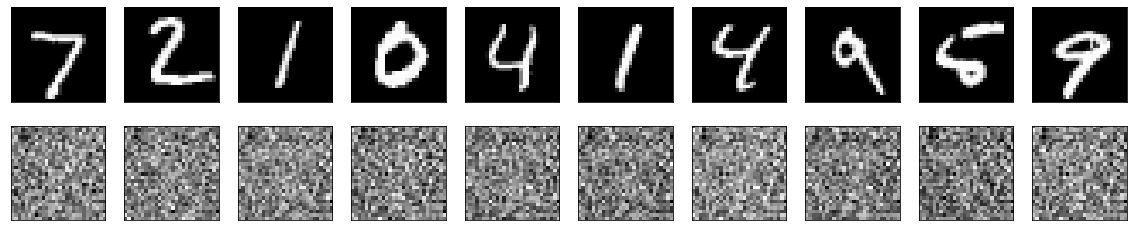

In [9]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [8]:
encoded_imgs.shape

(10000, 32)

____________________
### Based on Example from: https://medium.com/red-buffer/autoencoders-guide-and-code-in-tensorflow-2-0-a4101571ce56

In [8]:
# Load MNIST data and normalize to values between 0 and 1

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [101]:
# Auxiliar functions:
# Loss function, gradient function, generic function to train models (to train different models and compare), and a function to plot some digits to compare original vs different models.

import tensorflow as tf
import matplotlib.pyplot as plt
from typing import List

def loss(x: np.ndarray, x_bar: np.ndarray) -> float:
    return tf.losses.mean_squared_error(x, x_bar)

def grad(model: Model, inputs: np.ndarray):
    with tf.GradientTape() as tape:
        reconstruction, inputs_reshaped = model(inputs)
        loss_value = loss(inputs_reshaped, reconstruction)
    return loss_value, tape.gradient(loss_value, model.trainable_variables), inputs_reshaped, reconstruction

def train_model(model: Model):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    num_epochs = 10
    batch_size = 400

    for epoch in range(num_epochs):
        print("Epoch: ", epoch)
        for x in range(0, len(x_train), batch_size):
            x_inp = x_train[x : x + batch_size]
            loss_value, grads, inputs_reshaped, reconstruction = grad(model, x_inp)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        print("Step: {},Loss: {}".format(epoch, sum(loss(inputs_reshaped, reconstruction)/batch_size).numpy()))
        
def plot_predictions(models: List[Model]):
    predictions = []
    for m in models:
        predictions.append(np.array(m.predict(x_test)[0]))
    n = 10  # how many digits we will display
    rows = len(models) # how many rows to plot = number of models
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(rows+1, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        for idx,p in enumerate(predictions):
            ax = plt.subplot(rows+1, n, i + 1 + (idx+1)*n)
            plt.imshow(p[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

In [19]:
from tensorflow.keras.layers import Flatten

class FullyConnectedAutoEncoder(Model):
    def __init__(self):
        super(FullyConnectedAutoEncoder, self).__init__()
        self.flatten_layer = Flatten()
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(32, activation='relu')
        
        
        self.bottleneck = Dense(16, activation='relu')
    
        self.dense4 = Dense(32, activation='relu')
        self.dense5 = Dense(64, activation='relu')
        
        self.dense_final = Dense(784)
        
    
    def call(self, inp):
        x_reshaped = self.flatten_layer(inp)
        x = self.dense1(x_reshaped)
        x = self.dense2(x)
        x = self.bottleneck(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense_final(x)
        return x, x_reshaped

In [27]:
from tensorflow import Variable

model = FullyConnectedAutoEncoder()
train_model(model)

Epoch:  0
Step: 0,Loss: [0.05516481 0.0538431  0.03719277 0.0722165  0.03291824 0.07266439
 0.02491412 0.0455111  0.06977171 0.06184086 0.05412272 0.05451309
 0.05596528 0.04567328 0.03599786 0.05316624 0.02558533 0.05791623
 0.04871461 0.03314853 0.04630417 0.05535611 0.06393795 0.05238956
 0.04730892 0.02307966 0.04643617 0.06714911 0.06893849 0.03977259
 0.0437421  0.04644827 0.0396676  0.0329865  0.03112987 0.05392647
 0.0484722  0.05423652 0.04389761 0.04234386 0.04979698 0.05284144
 0.0542076  0.05989968 0.03547091 0.04786873 0.05916642 0.04406864
 0.05568331 0.05755344 0.038655   0.05526482 0.07095887 0.03365558
 0.04487131 0.06892338 0.0428795  0.0881175  0.06496087 0.05071153
 0.04186329 0.04123746 0.03401049 0.04919885 0.05399131 0.03392317
 0.05624879 0.04764765 0.03953824 0.09189007 0.06468042 0.01765054
 0.07133958 0.05064692 0.05521628 0.06834323 0.0524169  0.07328794
 0.05560039 0.05438285 0.06544846 0.06748152 0.04855421 0.05650758
 0.06897591 0.05161991 0.03007707 0.04

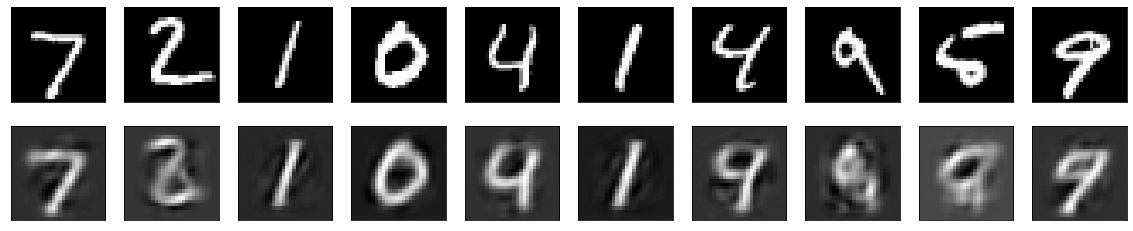

In [83]:
plot_predictions([model])

In [61]:
# Create an autoencoder with higher representation space.
class FullyConnectedAutoEncoder2(Model):
    def __init__(self):
        super(FullyConnectedAutoEncoder2, self).__init__()
        self.flatten_layer = Flatten()
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(32, activation='relu')
        
        self.bottleneck = Dense(32, activation='relu')
    
        self.dense4 = Dense(32, activation='relu')
        self.dense5 = Dense(64, activation='relu')
        
        self.dense_final = Dense(784)
        
    def call(self, inp):
        x_reshaped = self.flatten_layer(inp)
        x = self.dense1(x_reshaped)
        x = self.dense2(x)
        x = self.bottleneck(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense_final(x)
        return x, x_reshaped

In [64]:
# We train the new model
model2 = FullyConnectedAutoEncoder2()
train_model(model2)

Epoch:  0
Step: 0,Loss: 0.04062925651669502
Epoch:  1
Step: 1,Loss: 0.03072342276573181
Epoch:  2
Step: 2,Loss: 0.02734043449163437
Epoch:  3
Step: 3,Loss: 0.025500133633613586
Epoch:  4
Step: 4,Loss: 0.024704379960894585
Epoch:  5
Step: 5,Loss: 0.023997178301215172
Epoch:  6
Step: 6,Loss: 0.02356731705367565
Epoch:  7
Step: 7,Loss: 0.023335587233304977
Epoch:  8
Step: 8,Loss: 0.02316155470907688
Epoch:  9
Step: 9,Loss: 0.02293182536959648


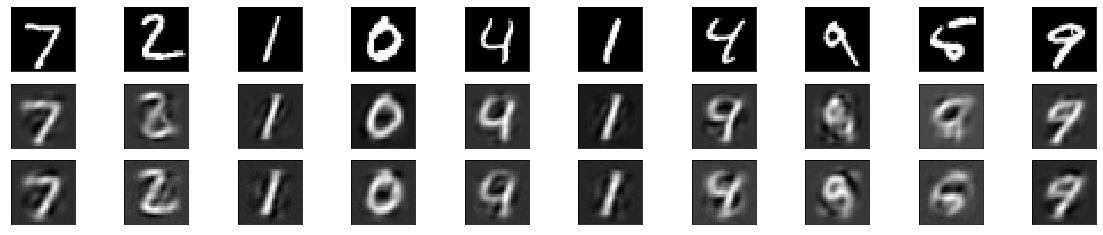

In [77]:
models = [model, model2]
plot_predictions(models)

In [80]:
# Create an autoencoder with even higher representation space, to compare.
class FullyConnectedAutoEncoder3(Model):
    def __init__(self):
        super(FullyConnectedAutoEncoder3, self).__init__()
        self.flatten_layer = Flatten()
        self.dense1 = Dense(256, activation='relu')
        self.dense2 = Dense(128, activation='relu')
        
        self.bottleneck = Dense(128, activation='relu')
    
        self.dense4 = Dense(128, activation='relu')
        self.dense5 = Dense(256, activation='relu')
        
        self.dense_final = Dense(784)
        
    def call(self, inp):
        x_reshaped = self.flatten_layer(inp)
        x = self.dense1(x_reshaped)
        x = self.dense2(x)
        x = self.bottleneck(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense_final(x)
        return x, x_reshaped

In [85]:
# We train the new model
model3 = FullyConnectedAutoEncoder3()
train_model(model3)


Epoch:  0
Step: 0,Loss: 0.027423512190580368
Epoch:  1
Step: 1,Loss: 0.01896778866648674
Epoch:  2
Step: 2,Loss: 0.016456490382552147
Epoch:  3
Step: 3,Loss: 0.014642487280070782
Epoch:  4
Step: 4,Loss: 0.013508899137377739
Epoch:  5
Step: 5,Loss: 0.012310666032135487
Epoch:  6
Step: 6,Loss: 0.01242324523627758
Epoch:  7
Step: 7,Loss: 0.01170544233173132
Epoch:  8
Step: 8,Loss: 0.01148737221956253
Epoch:  9
Step: 9,Loss: 0.010579783469438553


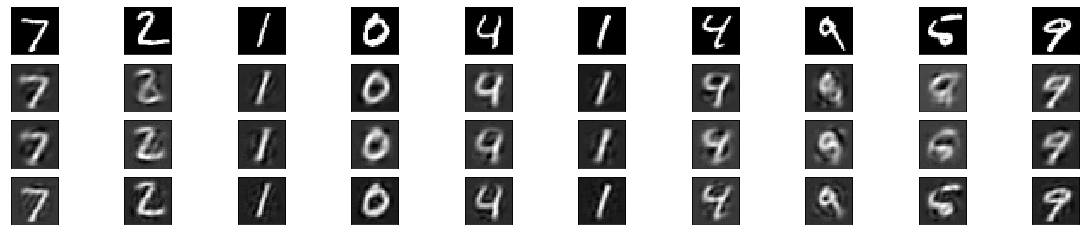

In [86]:
plot_predictions([model,model2,model3])

In [89]:
# Try to retrieve the encoding part of the autoencoder
# Then we want to train a classifier on the MNIST dataset and use as input the encoded input, and compare the accuracy of the different coding models.
model.layers[:4]

In [88]:
model.summary()

Model: "fully_connected_auto_encoder_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          multiple                  0         
_________________________________________________________________
dense_32 (Dense)             multiple                  50240     
_________________________________________________________________
dense_33 (Dense)             multiple                  2080      
_________________________________________________________________
dense_34 (Dense)             multiple                  528       
_________________________________________________________________
dense_35 (Dense)             multiple                  544       
_________________________________________________________________
dense_36 (Dense)             multiple                  2112      
_________________________________________________________________
dense_37 (Dense)             multipl

In [ ]:
# Create an autoencoder with even higher representation space, to compare.
class FullyConnectedAutoEncoder(Model):
    def __init__(self):
        super(FullyConnectedAutoEncoder, self).__init__()
        self.flatten_layer = Flatten()
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(32, activation='relu')
        
        
        self.bottleneck = Dense(16, activation='relu')
    
        self.dense4 = Dense(32, activation='relu')
        self.dense5 = Dense(64, activation='relu')
        
        self.dense_final = Dense(784)
        
    
    def call(self, inp):
        x_reshaped = self.flatten_layer(inp)
        x = self.dense1(x_reshaped)
        x = self.dense2(x)
        x = self.bottleneck(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense_final(x)
        return x, x_reshaped

In [ ]:
# Build the model with encoder and decoder separately? 
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import numpy as np

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))

flatten_input = Flatten()(input_img)
# "Encoder layers"
encoder1 = Dense(64, activation='relu')(input_img)
encoder2 = Dense(32, activation='relu')(encoder1)

# "Encoder output" - "bottleneck"
bottleneck = Dense(encoding_dim, activation='relu')(encoder2)

# "Decoder layers"

decoder1 = 

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [98]:
type(x_inp)

numpy.ndarray